# A2: Image classification in the brower

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there often isn’t  a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will run your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it. 

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on CourseWorks by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a screenshot of your model running in a webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [ ]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll see how-to write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. This code is written for you as an example. Follow along and try to understand each piece.


In [ ]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [ ]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/tulips/4521037085_70d5802e1d_m.jpg',
 '/root/.keras/datasets/flower_photos/daisy/18354545086_693ea7bc2a.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/4675287055_5938ed62c4.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/4632235020_d00ce1e497.jpg',
 '/root/.keras/datasets/flower_photos/roses/2713683760_d98cd2a05b_m.jpg']

### Get to know your data

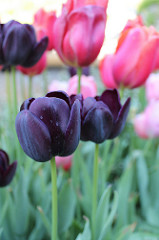

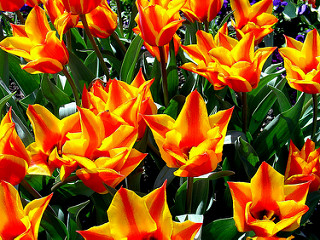

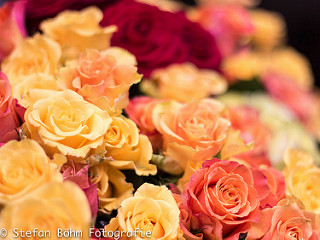

In [ ]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [4, 0, 1, 1, 2, 3, 2, 2, 0, 4]


### Create a train/test split

In [ ]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

tulips


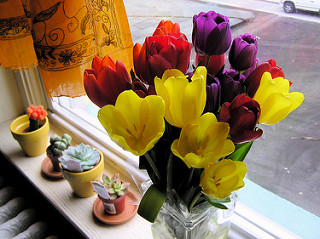


tulips


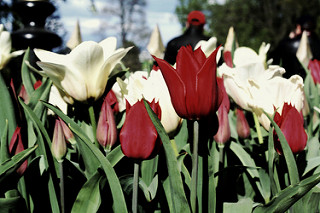


sunflowers


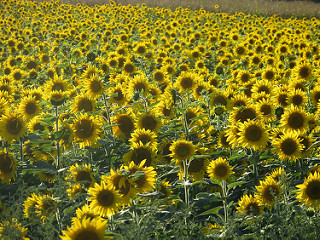

In [ ]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [ ]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [ ]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(240, 320, 3)
<dtype: 'uint8'>


In [ ]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

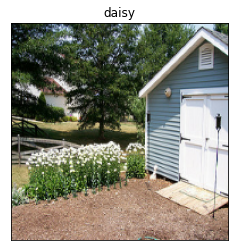

In [ ]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit). 

In [ ]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/835750256_3f91a147ef_n.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/17276354745_2e312a72b5_n.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/4563059851_45a9d21a75.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/14307766919_fac3c37a6b_m.jpg', shape=(), dtype=string)


In [ ]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [ ]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

daisy
dandelion
daisy
daisy


In [ ]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [ ]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) daisy
(192, 192, 3) dandelion


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [ ]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [ ]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [ ]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
17.40 Batches/s
556.88 Images/s
Total time: 4.94185471534729s


Now that the cache is built, iteration will be much faster.

In [ ]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
200.92 Batches/s
6429.43 Images/s
Total time: 0.42803192138671875s


### How-to use on-disk caching

If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones). For now, we'll keep it in memory.

In [ ]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN
This is our baseline model, it will not be very accurate. You'll improve it below.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient convolutional layers are than the dense layers (ask yourself,why?)

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in JavaScript in exactly the same way.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 144400)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 722005    
Total params: 722,453
Trainable params: 722,453
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# I realize we're not using a separate test set, that's fine
# for this assignment
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 6s 65ms/step - loss: 1.6985 - accuracy: 0.4266 - val_loss: 1.2459 - val_accuracy: 0.4847
Epoch 2/5
86/86 [==============================] - 1s 14ms/step - loss: 0.8828 - accuracy: 0.6817 - val_loss: 1.2858 - val_accuracy: 0.5185
Epoch 3/5
86/86 [==============================] - 1s 13ms/step - loss: 0.5173 - accuracy: 0.8401 - val_loss: 1.2773 - val_accuracy: 0.5458
Epoch 4/5
86/86 [==============================] - 1s 13ms/step - loss: 0.2862 - accuracy: 0.9310 - val_loss: 1.3479 - val_accuracy: 0.5686
Epoch 5/5
86/86 [==============================] - 1s 13ms/step - loss: 0.1432 - accuracy: 0.9786 - val_loss: 1.3001 - val_accuracy: 0.5948


### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [ ]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"
#########
im_batch = tf.expand_dims(img, axis=0) # YOUR CODE HERE, use tf.expand_dims

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction daisy
Actual daisy


### TODO: Improve accuracy
In the code cell below, write a new model that's more accurate than the baseline above. Define and train your model, and create plots of loss / accuracy as a function of epochs. Try to train your model to high accuracy, without overfitting. For this assignment, it is not necessary to build a super accurate model (just experiment a bit and try to improve over the baseline).

Epoch 1/5
86/86 [==============================] - 1s 15ms/step - loss: 1.3138 - accuracy: 0.4342 - val_loss: 1.2508 - val_accuracy: 0.4847
Epoch 2/5
86/86 [==============================] - 1s 14ms/step - loss: 1.1162 - accuracy: 0.5545 - val_loss: 1.1521 - val_accuracy: 0.5240
Epoch 3/5
86/86 [==============================] - 1s 13ms/step - loss: 1.0599 - accuracy: 0.5701 - val_loss: 1.2088 - val_accuracy: 0.5283
Epoch 4/5
86/86 [==============================] - 1s 13ms/step - loss: 0.9923 - accuracy: 0.6166 - val_loss: 1.0724 - val_accuracy: 0.5697
Epoch 5/5
86/86 [==============================] - 1s 13ms/step - loss: 0.9151 - accuracy: 0.6544 - val_loss: 1.0946 - val_accuracy: 0.5479


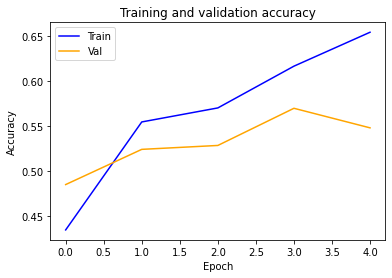

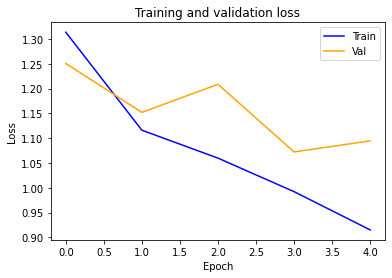

In [ ]:
# TODO: your code here

model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fit=model.fit(train_ds, validation_data=test_ds, epochs=5)

#reusing the plot function in HW1
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(fit)

## 1c) Practice deploying your flowers classifier using TensorFlow.js
In the final part of the assignment, you'll export the model you built to classify images from your house/apartment, and get it working in the browser. If you're new to JavaScript (as most of us are), the mechanics will be difficult at first. 

Let's practice by exporting your flowers classifier, and getting it working with TensorFlow.js (the starter code provided is written to work with flowers model).

### Save your model

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
!ls -lha

total 532K
drwxr-xr-x 1 root root 4.0K Oct 16 03:07 .
drwxr-xr-x 1 root root 4.0K Oct 16 02:53 ..
drwxr-xr-x 1 root root 4.0K Oct 14 16:32 .config
-rw-r--r-- 1 root root 515K Oct 16 03:07 my_model.h5
drwxr-xr-x 1 root root 4.0K Oct 14 16:31 sample_data


### Download your saved model to your local machine

In [ ]:
from google.colab import files
files.download("/content/my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visit notebook #2 (a2-2.ipynb on CourseWorks) to convert your saved model into to TensorFlow.js format

Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, you can continue with the rest of this assignment in this notebook.

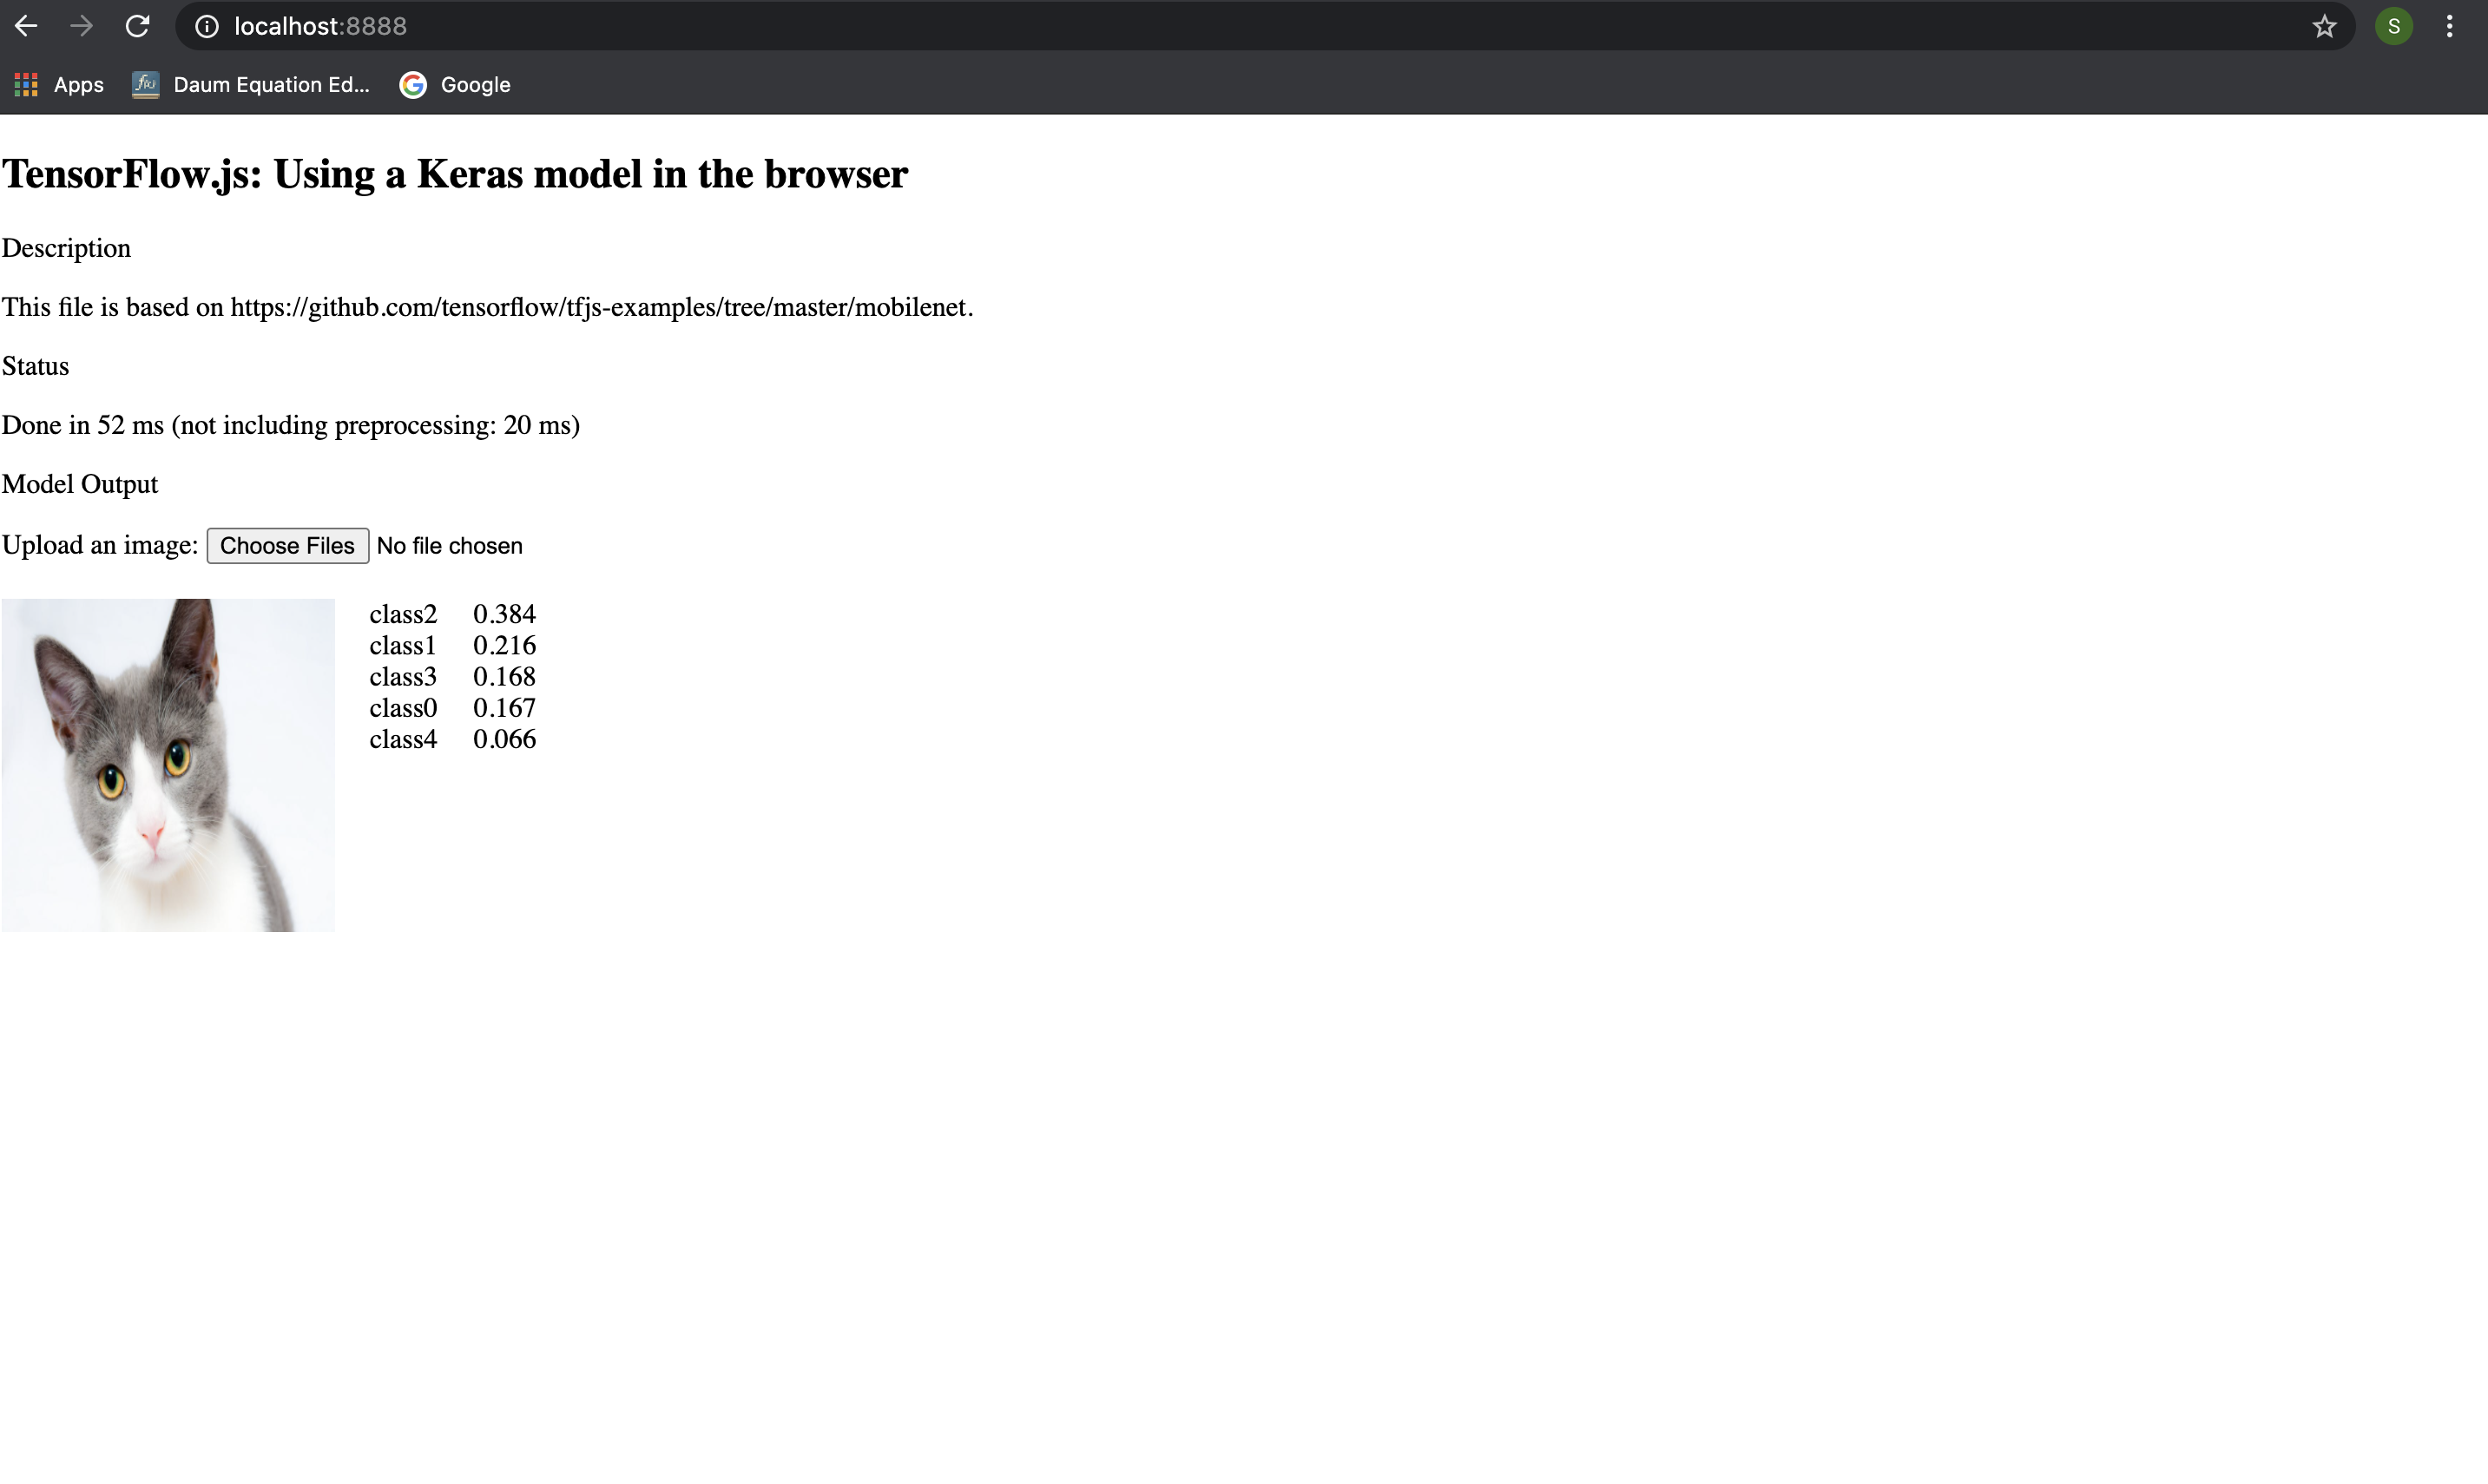

## 1d) Classify flowers using transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


Read this tutorial before completing this section:
* https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 

base_model = tf.keras.applications.MobileNetV2(input_shape=(192,192,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [ ]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False 

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [ ]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 4s 41ms/step - loss: 0.8033 - accuracy: 0.7148 - val_loss: 0.5072 - val_accuracy: 0.8203
Epoch 2/5
86/86 [==============================] - 3s 30ms/step - loss: 0.3942 - accuracy: 0.8670 - val_loss: 0.4175 - val_accuracy: 0.8453
Epoch 3/5
86/86 [==============================] - 3s 31ms/step - loss: 0.3069 - accuracy: 0.9015 - val_loss: 0.3922 - val_accuracy: 0.8519
Epoch 4/5
86/86 [==============================] - 3s 30ms/step - loss: 0.2549 - accuracy: 0.9168 - val_loss: 0.3712 - val_accuracy: 0.8682
Epoch 5/5
86/86 [==============================] - 3s 30ms/step - loss: 0.2220 - accuracy: 0.9313 - val_loss: 0.3593 - val_accuracy: 0.8736


## 2a) Collect your own dataset and train a model on it

In this part of the assignment, you will collect your own dataset, and train a model to classify your images. In previous semesters, students collected images from around Columbia's campus (famous statues, the library, etc). This semester, of course, you do not need to travel to campus. Instead, you can collect a dataset of any images you like (perhaps from around your apartment, or neighborhood). 

Instead of tf.data, you will gain experience with the higher level Keras utilities. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three items from your house/apartment, or from around your neighborhood. Your dataset should include at least 50 images of each object in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so, you can either upload it using the file browser (slow and tedious, you'll need to repeat that if your runtime is reset), or (better) you can upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`. As a another option, you could upload your dataset to a cloud provider or your Columbia account, then download it similarly to flowers at the top of this notebook.
 
1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning). 

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

In [ ]:
#I learned how to load images from google drive from https://colab.research.google.com/drive/1PKPUOlD5URcJTATdIrDCAFnxslTzxYAI#scrollTo=Yc-zdjQW1xZ1

#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='imagesdata.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('imagesdata.zip')
!unzip imagesdata.zip

Archive:  imagesdata.zip
   creating: imagesdata/
  inflating: imagesdata/.DS_Store    
  inflating: __MACOSX/imagesdata/._.DS_Store  
   creating: imagesdata/test/
   creating: imagesdata/train/
  inflating: imagesdata/test/.DS_Store  
  inflating: __MACOSX/imagesdata/test/._.DS_Store  
   creating: imagesdata/test/glasses/
   creating: imagesdata/test/case/
   creating: imagesdata/test/bottle/
  inflating: imagesdata/train/.DS_Store  
  inflating: __MACOSX/imagesdata/train/._.DS_Store  
   creating: imagesdata/train/glasses/
   creating: imagesdata/train/case/
   creating: imagesdata/train/bottle/
  inflating: imagesdata/test/glasses/IMG_2315_019.jpg  
  inflating: __MACOSX/imagesdata/test/glasses/._IMG_2315_019.jpg  
  inflating: imagesdata/test/glasses/IMG_2315_031.jpg  
  inflating: __MACOSX/imagesdata/test/glasses/._IMG_2315_031.jpg  
  inflating: imagesdata/test/glasses/IMG_2315_025.jpg  
  inflating: __MACOSX/imagesdata/test/glasses/._IMG_2315_025.jpg  
  inflating: imagesdata/

In [ ]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
IMG_SIZE=192
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/imagesdata/train',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=10)
validation_generator = test_datagen.flow_from_directory(
        '/content/imagesdata/test',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=10)

# for data_batch, labels_batch in train_generator:
#     print('data batch shape:', data_batch.shape)
#     print('labels batch shape:', labels_batch.shape)
#     break

model = models.Sequential()
model.add(layers.Conv2D(20, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(40, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(80, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(100, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=18,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10)

Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
18/18 [==============================] - 8s 433ms/step - loss: 0.7016 - accuracy: 0.7500 - val_loss: 0.7254 - val_accuracy: 0.7200
Epoch 2/10
18/18 [==============================] - 7s 414ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 2.5075 - val_accuracy: 0.8100
Epoch 3/10
18/18 [==============================] - 7s 415ms/step - loss: 1.7728e-05 - accuracy: 1.0000 - val_loss: 2.2976 - val_accuracy: 0.9100
Epoch 4/10
18/18 [==============================] - 7s 410ms/step - loss: 3.9736e-08 - accuracy: 1.0000 - val_loss: 4.4079 - val_accuracy: 0.8600
Epoch 5/10
18/18 [==============================] - 8s 420ms/step - loss: 1.8544e-08 - accuracy: 1.0000 - val_loss: 3.0126 - val_accuracy: 0.9000
Epoch 6/10
18/18 [==============================] - 8s 422ms/step - loss: 1.7881e-08 - accuracy: 1.0000 - val_loss: 1.91

In [ ]:
model.save('before_aug.h5')

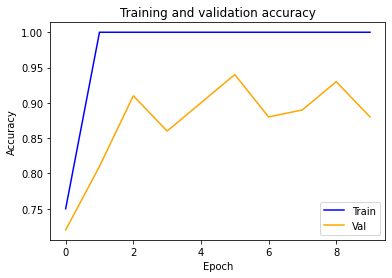

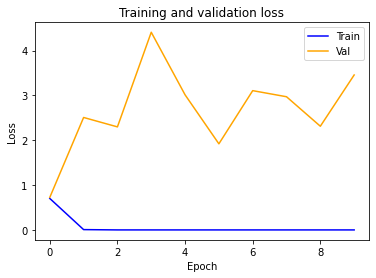

In [ ]:
plot(history)

Prediction bottle



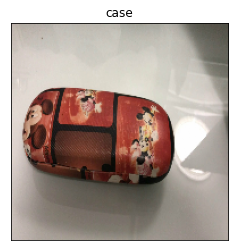

In [ ]:
img = load_and_preprocess_image('/content/imagesdata/test/case/IMG_2305_000.jpg')
im_batch = tf.expand_dims(img, axis=0) 
pred = model.predict(im_batch)[0]
label_names=['bottle','case','glasses']
print("Prediction", label_names[tf.argmax(pred)])
show(img,"case")

Prediction glasses



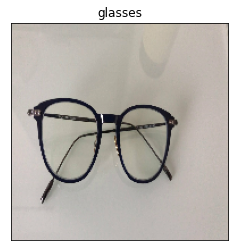

In [ ]:
img = load_and_preprocess_image('/content/imagesdata/test/glasses/IMG_2315_000.jpg')
im_batch = tf.expand_dims(img, axis=0) 
pred = model.predict(im_batch)[0]
print("Prediction", label_names[tf.argmax(pred)])
show(img,"glasses")

Prediction bottle



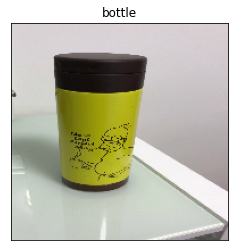

In [ ]:
img = load_and_preprocess_image('/content/imagesdata/test/bottle/IMG_2309_000.jpg')
im_batch = tf.expand_dims(img, axis=0) 
pred = model.predict(im_batch)[0]
print("Prediction", label_names[tf.argmax(pred)])
show(img,"bottle")

In [ ]:
from keras.preprocessing.image import img_to_array, load_img
from numpy import *
import numpy as np
import PIL
from PIL import Image
import os
new_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.05,
      zoom_range=0.05,
      horizontal_flip=False,
      vertical_flip=False,)

def aug(label):
  for l in os.listdir('/content/imagesdata/train/'+label):
    if l!='.DS_Store':
      img=Image.open('/content/imagesdata/train/'+label+'/'+l)
      new_img=img.resize((IMG_SIZE,IMG_SIZE), Image.ANTIALIAS)
      # new_img.save('/content/imagesdata/train/'+label+'/'+l, "JPEG", quality=100)
      x=img_to_array(new_img).transpose(0,1,2)
      x=x.reshape((1,)+x.shape)
      i=0
      for batch in new_gen.flow(x,seed=1,batch_size=1,save_to_dir='/content/imagesdata/train/'+label+'/',save_prefix='aug',save_format='jpg'):
        i+=1
        if i==20:
          break

aug('bottle')
aug('glasses')
aug('case')

In [ ]:
train_generator = train_datagen.flow_from_directory(
        '/content/imagesdata/train',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=10)
validation_generator = test_datagen.flow_from_directory(
        '/content/imagesdata/test',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=10)

model = tf.keras.Sequential()
model.add(layers.Conv2D(20, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(40, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(80, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(100, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=24,
      epochs=6,
      validation_data=validation_generator,
      validation_steps=10)

Found 240 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Epoch 1/6
24/24 [==============================] - 8s 348ms/step - loss: 0.7259 - accuracy: 0.7375 - val_loss: 0.3731 - val_accuracy: 0.8600
Epoch 2/6
24/24 [==============================] - 8s 330ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.5106 - val_accuracy: 0.9200
Epoch 3/6
24/24 [==============================] - 8s 323ms/step - loss: 1.4637e-06 - accuracy: 1.0000 - val_loss: 0.5796 - val_accuracy: 0.8800
Epoch 4/6
24/24 [==============================] - 8s 322ms/step - loss: 1.4612e-06 - accuracy: 1.0000 - val_loss: 0.6128 - val_accuracy: 0.9100
Epoch 5/6
24/24 [==============================] - 8s 320ms/step - loss: 1.1498e-06 - accuracy: 1.0000 - val_loss: 0.8592 - val_accuracy: 0.8900
Epoch 6/6
24/24 [==============================] - 8s 326ms/step - loss: 9.2532e-07 - accuracy: 1.0000 - val_loss: 0.7036 - val_accuracy: 0.8700


After data augmentation, accuracy improves compared with what I had before, and the level of overfitting is less than before. 

In [ ]:
model.save('after_aug.h5')

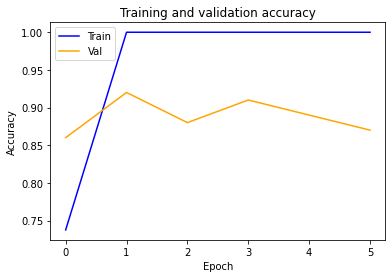

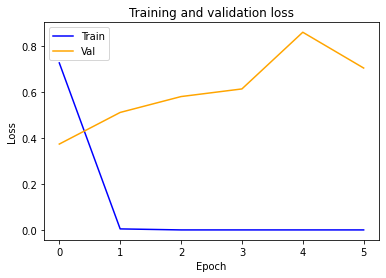

In [ ]:
plot(history)

## 2b) Run your model in the browser
Save and download your model, and head to notebook two again. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc. Take a screenshot of your model running in a webpage and include it with your submission.

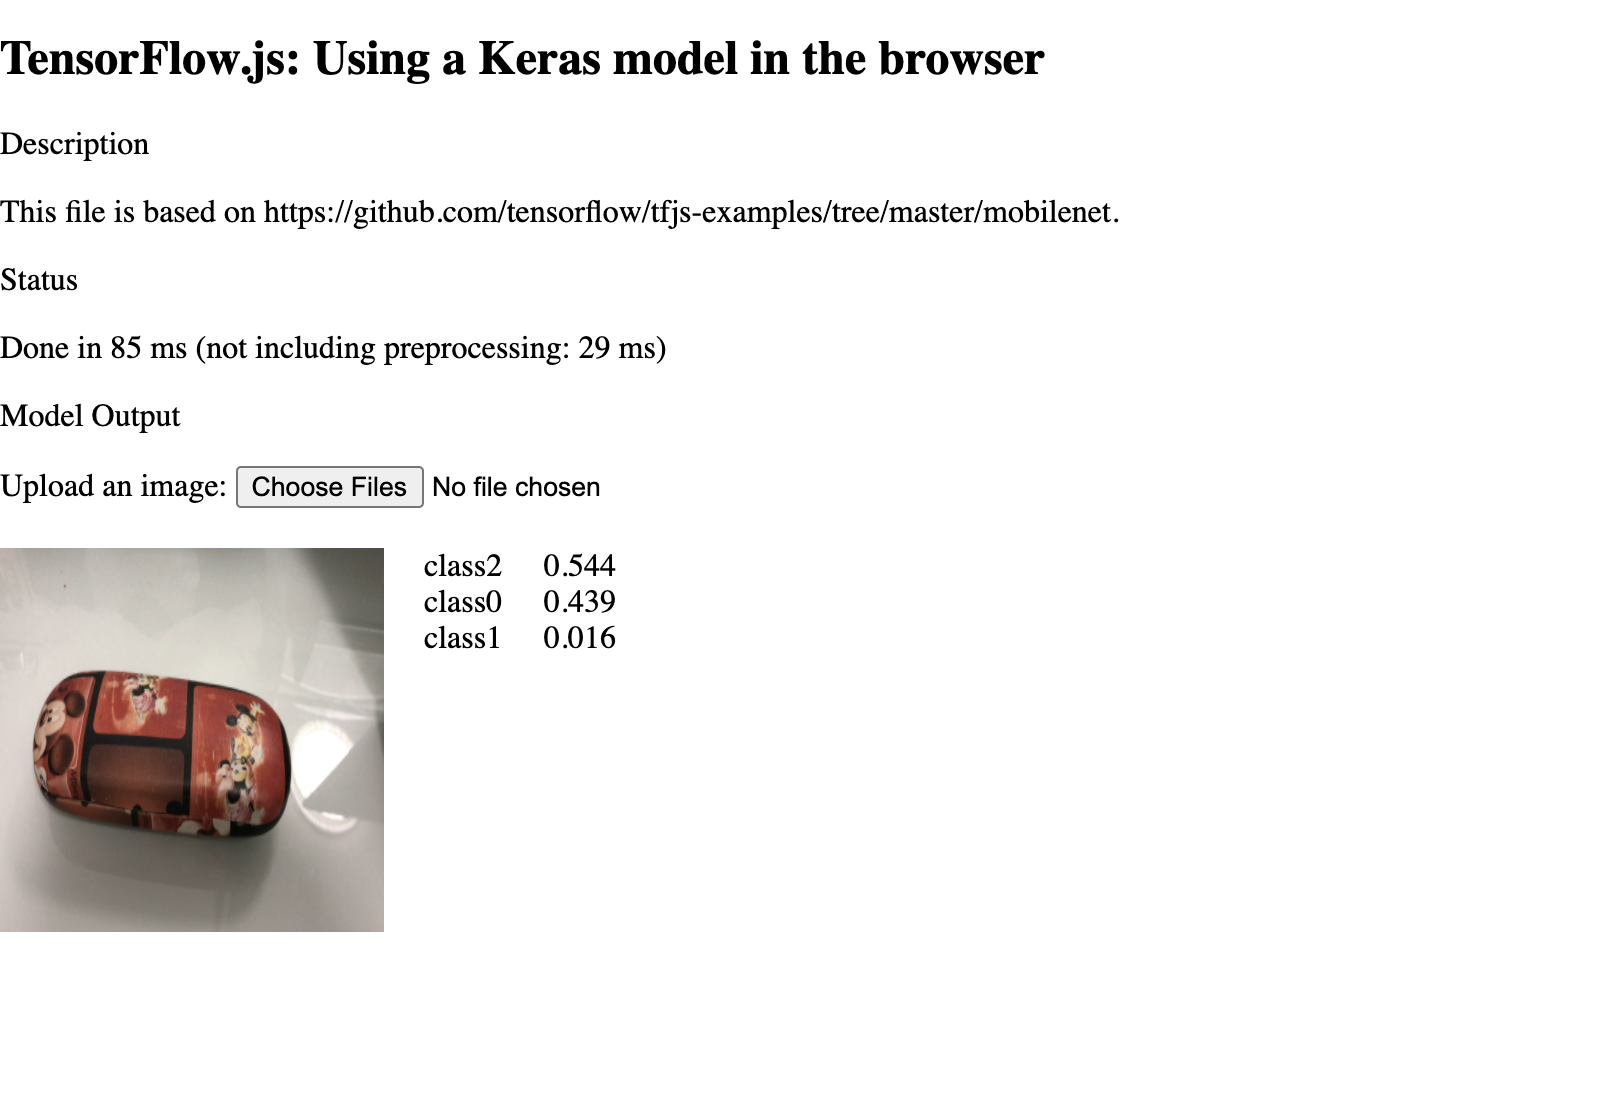